In [1]:
# All libraries
import jetset
print('tested on jetset',jetset.__version__)
import warnings
warnings.filterwarnings('ignore')
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from jetset.data_loader import Data
from jetset.data_loader import ObsData
from jetset.plot_sedfit import PlotSED
from jetset.jet_model import Jet
from jetset.minimizer import fit_SED,ModelMinimizer
from jetset.model_manager import  FitModel
from jetset.sed_shaper import  SEDShape
from jetset.obs_constrain import ObsConstrain
from jetset.minimizer import fit_SED
from jetset.template_2Dmodel import EBLAbsorptionTemplate
from jetset.mcmc import McmcSampler
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.dpi'] = 200
plt.rcParams["savefig.bbox"] = 'tight'

tested on jetset 1.2.2


---> excluding  data_set/s ['-1']
filter -1 38
current datasets
dataset 0.0
---> data sets left after filtering None
---> data len after filtering=38

***  binning data  ***
---> N bins= 113
---> bin_widht= 0.15

---> setting  UL
---> Settin  UL for val [0, 0, 2.94e-13, 7.22e-14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.3773e-11, 0, 0, 0, 0, 1.3805e-13, 7.9016e-13, 5.2788e-13]


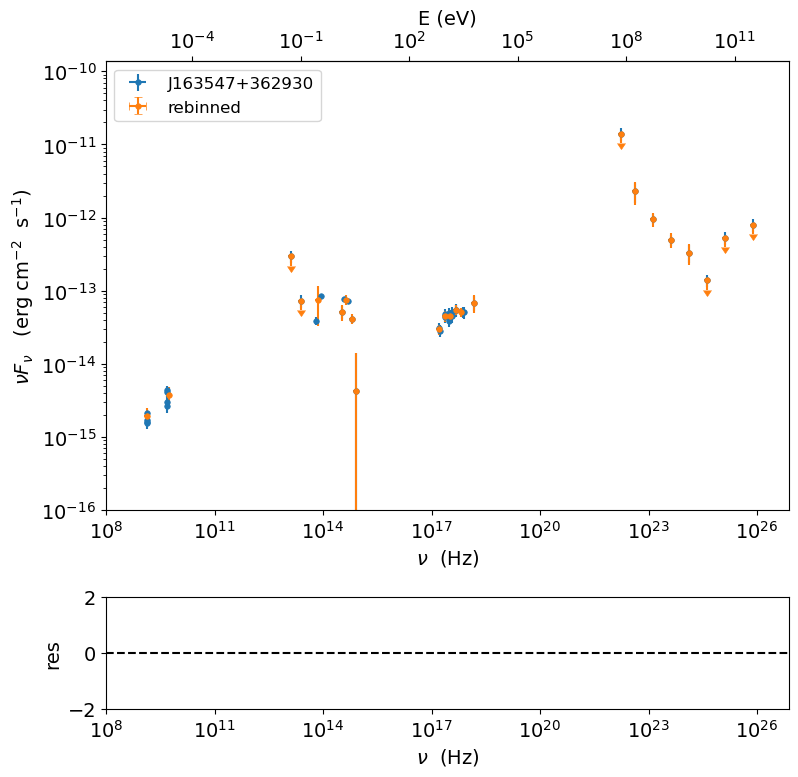

In [2]:
d=np.genfromtxt('sed2.txt')
data=Data(n_rows=d.shape[0])
data.set_field('x',d[:,0])
data.set_field('y',d[:,1])
data.set_field('dy',value=d[:,2])
#data.table[22]['UL']=True
#data.table[23]['UL']=True
data.set_meta_data('z',3.647763)
data.set_meta_data('UL_CL', 0.95)
data.set_meta_data('restframe','obs')
data.set_meta_data('data_scale','lin-lin')
data.set_meta_data('obj_name','J163547+362930')

sed_data=ObsData(data_table=data)
myPlot=sed_data.plot_sed()
sed_data.filter_data_set('-1',exclude=True)
sed_data.group_data(bin_width=.15)
sed_data.add_systematics(0.15,[10.**6,10.**29])
sed_data.set_UL([0,0,2.94E-13,7.22e-14,0,0,0,0,
                 0,0,0,0,0,0,0,1.3773E-11,0,0,0,
                 0,1.3805E-13,7.9016E-13,5.2788E-13])
myPlot.add_data_plot(sed_data,label='rebinned')
myPlot.setlim(y_min=1E-16,x_min=1E8)
myPlot.sedplot.legend(loc='upper left',fontsize=12)
myPlot.sedplot.grid(False)
myPlot.save('bin.png')

sed_data.save('J163547_data.pkl')


*** evaluating spectral indices for data ***
!Warning, no covariance matrix produced
!Warning, no covariance matrix produced
!Warning, no covariance matrix produced



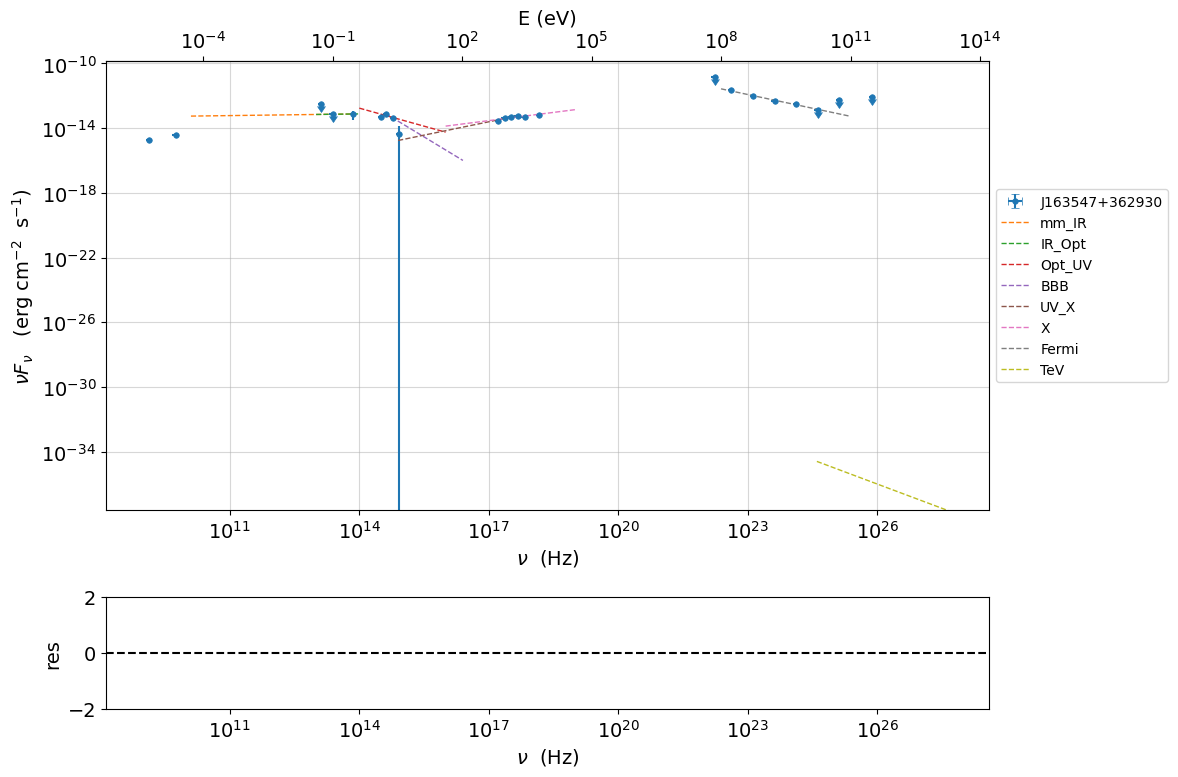

In [3]:
my_shape=SEDShape(sed_data)
my_shape.eval_indices(silent=True)
p=my_shape.plot_indices()


*** Log-Polynomial fitting of the synchrotron component ***
---> first blind fit run,  fit range: [9, 16]
--> class:  LSP

--> class:  LSP




model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
LogParabolaEp,b,-7.654251e-02,-7.654251e-02,3.570387e-02,--,-8.702503e-02,-1.000000e+01,0.000000e+00,False
LogParabolaEp,Ep,1.334218e+01,1.334218e+01,7.365025e-01,--,1.346721e+01,0.000000e+00,3.000000e+01,False
LogParabolaEp,Sp,-1.338911e+01,-1.338911e+01,1.716512e-01,--,-1.313772e+01,-3.000000e+01,0.000000e+00,False
BBB,nuFnu_p_BBB,-1.358901e+01,-1.358901e+01,1.644876e-01,--,-1.313772e+01,-1.513772e+01,-1.113772e+01,False
BBB,nu_scale,2.929155e-03,2.929155e-03,3.906786e-03,--,0.000000e+00,-5.000000e-01,5.000000e-01,False


---> sync       nu_p=+1.334218e+01 (err=+7.365025e-01)  nuFnu_p=-1.338911e+01 (err=+1.716512e-01) curv.=-7.654251e-02 (err=+3.570387e-02)


*** Log-Polynomial fitting of the IC component ***
---> fit range: [16, 26]
---> LogCubic fit




model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
LogCubic,b,-1.544016e-01,-1.544016e-01,2.330447e-02,--,-1.000000e+00,-1.000000e+01,0.000000e+00,False
LogCubic,c,-1.695565e-02,-1.695565e-02,4.603073e-03,--,-1.000000e+00,-1.000000e+01,1.000000e+01,False
LogCubic,Ep,2.204483e+01,2.204483e+01,1.468777e-01,--,2.078294e+01,0.000000e+00,3.000000e+01,False
LogCubic,Sp,-1.177452e+01,-1.177452e+01,1.070618e-01,--,-1.000000e+01,-3.000000e+01,0.000000e+00,False


---> IC         nu_p=+2.204483e+01 (err=+1.468777e-01)  nuFnu_p=-1.177452e+01 (err=+1.070618e-01) curv.=-1.544016e-01 (err=+2.330447e-02)



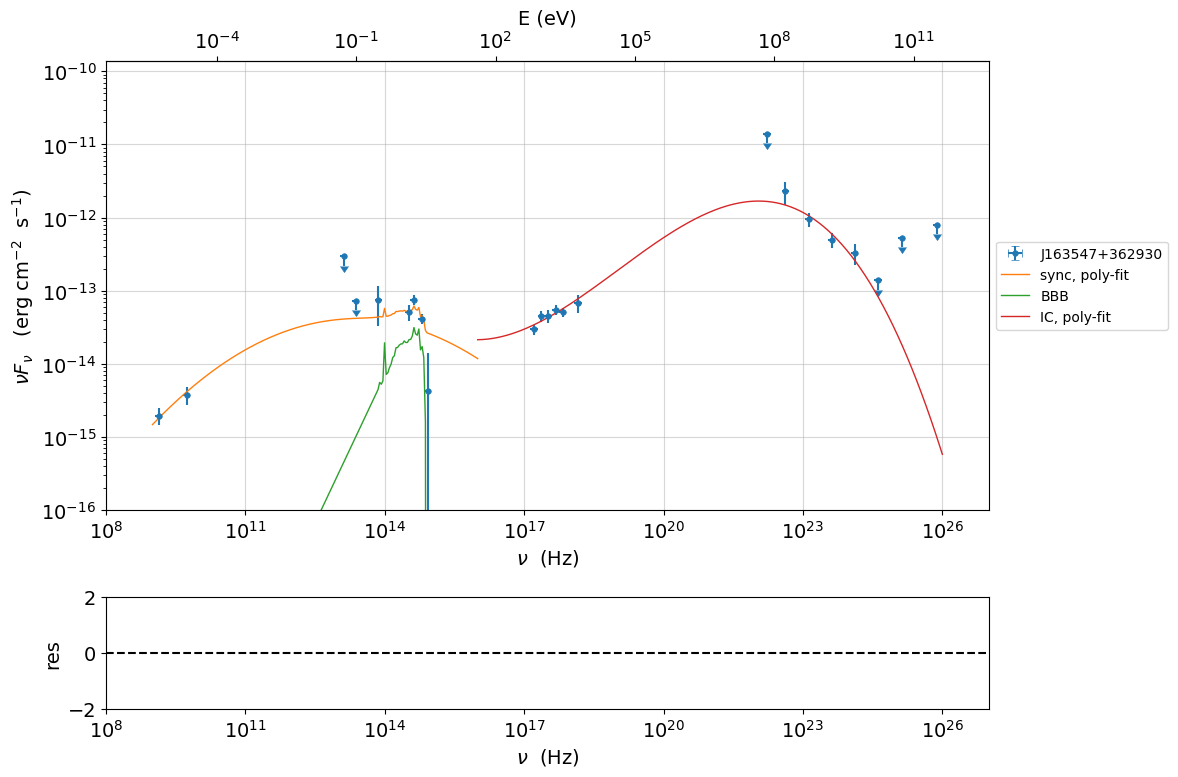

In [4]:
mm,best_fit=my_shape.sync_fit(check_BBB_template=True,
                              check_host_gal_template=False,
                              use_log_par=True,
                              Ep_start=None,
                              minimizer='lsb',
                              silent=True,
                              fit_range=[9,16])
my_shape.IC_fit(fit_range=[16,26],minimizer='minuit', silent=True)
p=my_shape.plot_shape_fit()
p.setlim(y_min=1E-16)


***  constrains parameters from observable ***



model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,R,region_size,cm,7.450084e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.500000e+18,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,5.000000e-02,0.000000e+00,--,False,False
jet_leptonic,NH_cold_to_rel_e,cold_p_to_rel_e_ratio,,1.000000e-01,0.000000e+00,--,False,True
jet_leptonic,theta,jet-viewing-angle,deg,3.000000e+00,0.000000e+00,--,False,False
jet_leptonic,BulkFactor,jet-bulk-factor,lorentz-factor*,1.850000e+01,1.000000e+00,1.000000e+05,False,False
jet_leptonic,z_cosm,redshift,,3.647763e+00,0.000000e+00,--,False,False
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,3.627019e+01,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,3.316293e+04,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,4.199502e+02,0.000000e+00,--,False,False




19.097330879509727


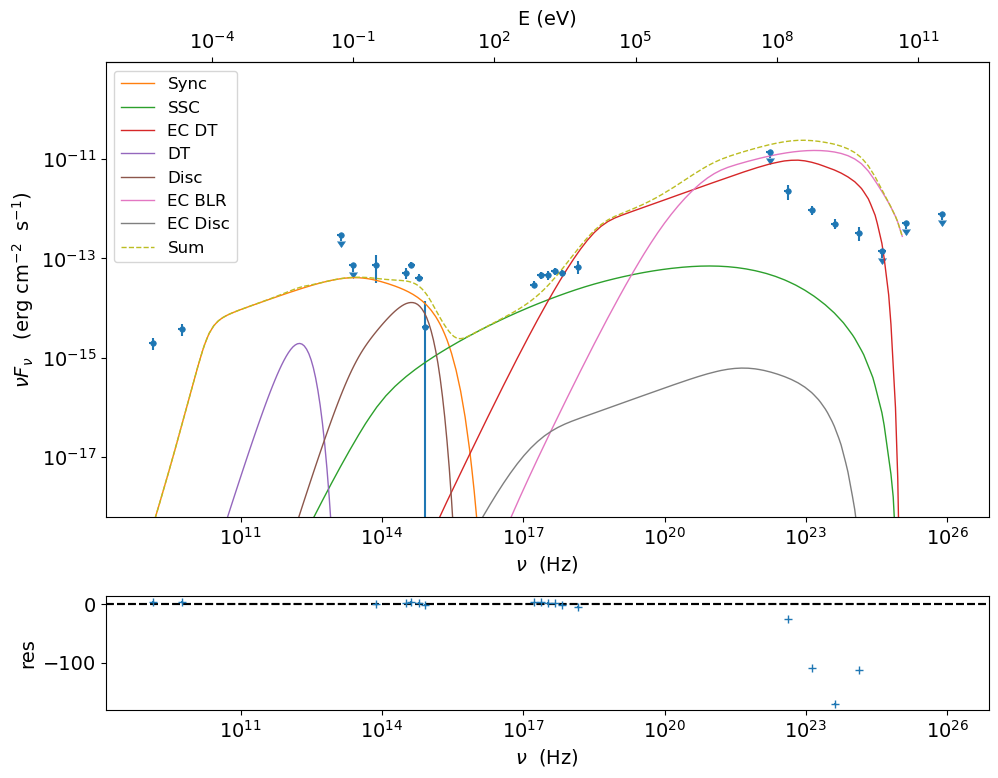

In [5]:
sed_obspar=ObsConstrain(theta=3,
                        bulk_factor=18.5,
                        B_range=[0.02,0.08],
                        distr_e='bkn',
                        t_var_sec=7*86400,
                        nu_cut_IR=1E9,
                        SEDShape=my_shape)


prefit_jet=sed_obspar.constrain_SSC_EC_model(electron_distribution_log_values=False,
                                             EC_componets_list=['EC_DT','EC_BLR','EC_Disk'],
                                             R_H=1.5E18,
                                             disk_type='MultiBB',
                                             silent=True)
prefit_jet.eval()
p=prefit_jet.plot_model(sed_data=sed_data)
p.add_residual_plot(prefit_jet,sed_data)
p.sedplot.legend(loc='upper left',fontsize=12)
p.sedplot.grid(False)
p.setlim(y_max=9e-10)
legend_labels = ['Sync', 'SSC', 'EC DT', 'DT', 'Disc', 'EC BLR', 'EC Disc', 'Sum']
p.sedplot.legend(labels = legend_labels, loc='upper left', fontsize=12)
p.save('prefit3.png')
print(prefit_jet.get_beaming())
prefit_jet.save_model('PrePre3.pkl')

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,3.267129e+01,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.987235e+04,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,4.413552e+02,0.000000e+00,--,False,False
jet_leptonic,gamma_break,turn-over-energy,lorentz-factor*,3.806596e+03,1.000000e+00,1.000000e+09,False,False
jet_leptonic,p,LE_spectral_slope,,2.320657e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,p_1,HE_spectral_slope,,3.500000e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,T_DT,DT,K,1.000000e+02,0.000000e+00,--,False,False
jet_leptonic,R_DT,DT,cm,5.000000e+18,0.000000e+00,--,False,False
jet_leptonic,tau_DT,DT,,1.000000e-01,0.000000e+00,1.000000e+00,False,False
jet_leptonic,R_inner_Sw,Disk,Sw. radii*,3.000000e+00,0.000000e+00,--,False,False


==> par R is now depending on ['R_H', 'theta_open'] according to expr:R =
np.tan((theta_open*np.pi/180))*R_H
==> par R_BLR_in is now depending on ['L_Disk'] according to expr:R_BLR_in =
3E17*(L_Disk/1E46)**0.5
==> par R_BLR_out is now depending on ['R_BLR_in'] according to expr:R_BLR_out =
R_BLR_in*1.1
==> par R_DT is now depending on ['L_Disk'] according to expr:R_DT =
2E19*(L_Disk/1E46)**0.5


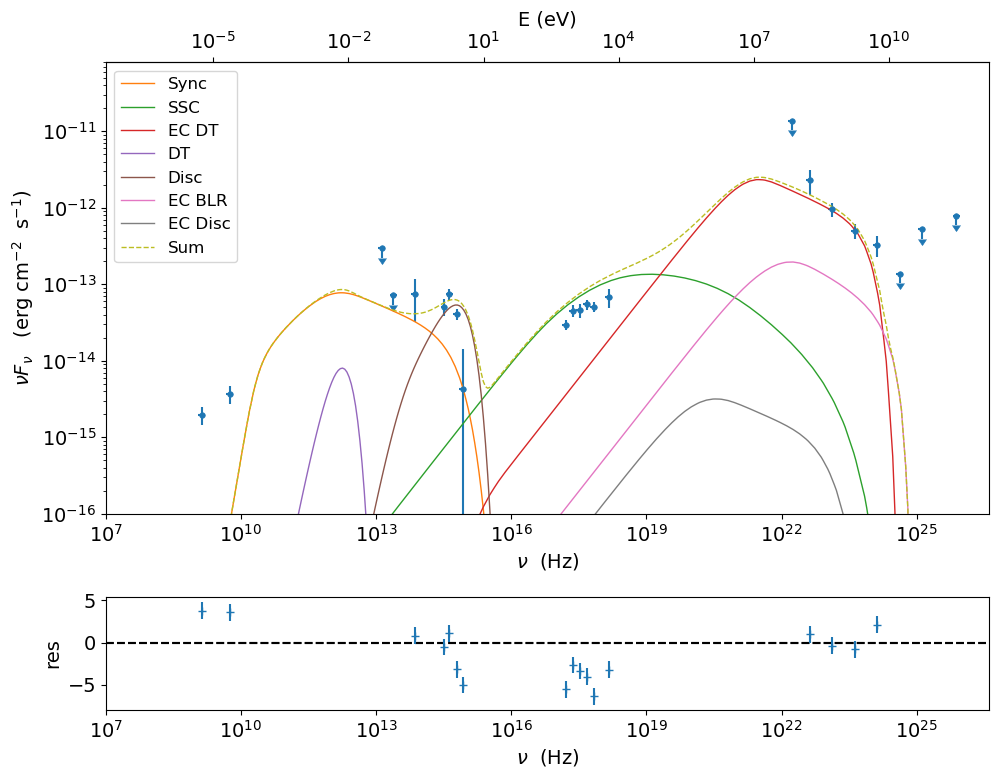

In [6]:
sed_data = ObsData.load('J163547_data.pkl')
prefit_jet=Jet.load_model('PrePre.pkl')
prefit_jet.add_user_par(name='theta_open',val=3,units='deg')
prefit_jet.make_dependent_par(par='R', depends_on=['R_H','theta_open'],
                              par_expr='np.tan((theta_open*np.pi/180))*R_H')

prefit_jet.make_dependent_par(par='R_BLR_in', depends_on=['L_Disk'], par_expr='3E17*(L_Disk/1E46)**0.5')
prefit_jet.make_dependent_par(par='R_BLR_out', depends_on=['R_BLR_in'], par_expr='R_BLR_in*1.1')
prefit_jet.make_dependent_par(par='R_DT', depends_on=['L_Disk'], par_expr='2E19*(L_Disk/1E46)**0.5')

prefit_jet.set_par('L_Disk',val=1.381e46)
prefit_jet.set_par('gmin',val=1.00)
prefit_jet.set_par('gmax',val=2.00e4)
prefit_jet.set_par('gamma_break',val=1.00e3)
prefit_jet.set_par('N',val=1.50e3)
prefit_jet.set_par('p',val=1.5)
prefit_jet.eval()
#prefit_jet.show_model()
p=prefit_jet.plot_model(sed_data=sed_data, frame='obs')
p.add_residual_plot(prefit_jet,sed_data)
p.sedplot.legend(loc='upper left',fontsize=12)
p.sedplot.grid(False)
p.setlim(x_min=1e7,x_max=4e26,y_min=1.0e-16,y_max=8e-11)
legend_labels = ['Sync', 'SSC', 'EC DT', 'DT', 'Disc', 'EC BLR', 'EC Disc', 'Sum']
p.sedplot.legend(labels = legend_labels, loc='upper left', fontsize=12)
p.save('prefit2_3.png')

filtering data in fit range = [1.000000e+08,1.000000e+30]
data length 23

*** start fit process ***
----- 
fit run: 0


0it [00:00, ?it/s]

- best chisq=3.74868e+01

fit run: 1
- old chisq=3.74868e+01


0it [00:00, ?it/s]

- best chisq=3.73836e+01

fit run: 2
- old chisq=3.73836e+01


0it [00:00, ?it/s]

- best chisq=3.73092e+01

-------------------------------------------------------------------------
Fit report

Model: Sum


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.000000e+00,1.000000e+00,1.000000e+09,False,True
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.000000e+04,1.000000e+00,1.000000e+15,False,True
jet_leptonic,N,emitters_density,1 / cm3,9.214208e+02,0.000000e+00,--,False,False
jet_leptonic,gamma_break,turn-over-energy,lorentz-factor*,9.463835e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,p,LE_spectral_slope,,1.446258e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,p_1,HE_spectral_slope,,3.576325e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,T_DT,DT,K,9.268273e+02,0.000000e+00,--,False,False
jet_leptonic,"*R_DT(D,L_Disk)",DT,cm,2.373137e+19,0.000000e+00,--,False,True
jet_leptonic,tau_DT,DT,,1.000000e-01,0.000000e+00,1.000000e+00,False,True
jet_leptonic,R_inner_Sw,Disk,Sw. radii*,9.274387e+00,0.000000e+00,--,False,False



converged=True
calls=988
mesg=


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 37.31                      │              Nfcn = 988              │
│ EDM = 0.65 (Goal: 0.0002)        │           time = 305.4 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ ABOVE EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ par_0  │  0.92e3   │  0.12e3   │            │            │   400   │  2000   │       │
│ 1 │ par_1  │  0.95e3   │  0.13e3   │            │            │   800   │  2000   │       │
│ 2 │ par_2  │   1.446   │   0.028   │            │            │  1.35   │   1.6   │       │
│ 3 │ par_3  │   3.58    │   0.25    │            │            │    3    │   3.8   │       │
│ 4 │ par_4  │   0.9e3   │   0.7e3   │            │            │   100   │  1000   │       │
│ 5 │ par_5  │    9.3    │    1.9    │            │            │    3    │   15    │       │
│ 6 │ par_6  │   0.8e3   │   0.6e3   │            │            │   50    │  1000   │       │
│ 7 │ par_7  │  1.10e9   │  0.06e9   │            │            │  5e+08  │  2e+09  │       │
│ 8 │ par_8  │ 14.08e45  │  0.05e45  │            │            │  1e+46  │  5e+46  │       │
│ 9 │ par_9  │ 1.500e18  │ 0.005e18  │            │            │  5e+17  │  3e+18  │       │
│ 10│ par_10 │   0.066   │   0.010   │            │            │  0.01   │   0.1   │       │
│ 11│ par_11 │    19     │     5     │            │            │   10    │   25    │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│        │     par_0     par_1     par_2     par_3     par_4     par_5     par_6     par_7     par_8     par_9    par_10    par_11 │
├────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│  par_0 │  1.42e+04 -4.75e+03       1.4      3.66 -5.26e+03     -36.2  -8.5e+03 -3.26e+07 -1.04e+44 -4.44e+16    -0.296       101 │
│  par_1 │ -4.75e+03  1.79e+04      1.13     -7.68  2.32e+04      26.3  1.04e+04  2.73e+07  3.72e+44  8.03e+16    -0.524      -454 │
│  par_2 │       1.4      1.13  0.000816 -0.000711     0.825   0.00803      1.76  7.14e+03  1.75e+40   8.6e+12  7.22e-05   -0.0158 │
│  par_3 │      3.66     -7.68 -0.000711    0.0733     -69.8    -0.216     -53.1 -1.98e+05 -1.08e+42 -2.82e+14  0.000999      1.37 │
│  par_4 │ -5.26e+03  2.32e+04     0.825     -69.8  9.35e+04       182  9.29e+04  1.84e+08  2.12e+45  5.09e+17      -1.8 -1.81e+03 │
│  par_5 │     -36.2      26.3   0.00803    -0.216       182      3.59       284 -2.99e+07  5.52e+42  7.67e+14   0.00127     -3.54 │
│  par_6 │  -8.5e+03  1.04e+04      1.76     -53.1  9.29e+04       284  2.11e+06  -2.2e+09   1.7e+45  3.94e+17    -0.613 -1.82e+03 │
│  par_7 │ -3.26e+07  2.73e+07  7.14e+03 -1.98e+05  1.84e+08 -2.99e+07  -2.2e+09  3.89e+15  5.14e+48  8.18e+20       670 -3.59e+06 │
│  par_8 │ -1.04e+44  3.72e+44  1.75e+40 -1.08e+42  2.12e+45  5.52e+42   1.7e+45  5.14e+48  2.81e+87 -6.03e+58 -2.04e+40 -4.14e+43 │
│  p

dof=11
chisq=37.309157, chisq/red=3.391742 null hypothesis sig=0.000102

stats without the UL
dof  UL=5
chisq=37.212731, chisq/red=7.442546 null hypothesis sig=0.000001


best fit pars


model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
jet_leptonic,gmin,1.000000e+00,--,--,--,1.000000e+00,1.000000e+00,1.000000e+09,True
jet_leptonic,gmax,2.000000e+04,--,--,--,2.000000e+04,1.000000e+00,1.000000e+15,True
jet_leptonic,N,9.214208e+02,9.214208e+02,1.184678e+02,--,1.500000e+03,4.000000e+02,2.000000e+03,False
jet_leptonic,gamma_break,9.463835e+02,9.463835e+02,1.310634e+02,--,1.000000e+03,8.000000e+02,2.000000e+03,False
jet_leptonic,p,1.446258e+00,1.446258e+00,2.830244e-02,--,1.500000e+00,1.350000e+00,1.600000e+00,False
jet_leptonic,p_1,3.576325e+00,3.576325e+00,2.457928e-01,--,3.500000e+00,3.000000e+00,3.800000e+00,False
jet_leptonic,T_DT,9.268273e+02,9.268273e+02,6.942098e+02,--,1.000000e+02,1.000000e+02,1.000000e+03,False
jet_leptonic,"*R_DT(D,L_Disk)",2.373137e+19,--,--,--,2.350319e+19,0.000000e+00,--,True
jet_leptonic,tau_DT,1.000000e-01,--,--,--,1.000000e-01,0.000000e+00,1.000000e+00,True
jet_leptonic,R_inner_Sw,9.274387e+00,9.274387e+00,1.864463e+00,--,3.000000e+00,3.000000e+00,1.500000e+01,False


-------------------------------------------------------------------------



--------------------------------------------------------------------------------
Composite model description
--------------------------------------------------------------------------------
name: Standard SSD  
type: composite_model  
components models:
 -model name: jet_leptonic model type: jet

--------------------------------------------------------------------------------
individual component description

--------------------------------------------------------------------------------
model description: 
--------------------------------------------------------------------------------
type: Jet
name: jet_leptonic  

electrons distribution:
 type: bkn  
 gamma energy grid size:  201
 gmin grid : 1.000000e+00
 gmax grid : 2.000000e+04
 normalization:  True
 log-values:  False
 ratio of cold protons to relativistic electrons: 1.000000e-01

accretion disk:
 disk Type: MultiBB
 L disk: 1.407945e+46 (erg/s)
 T di

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.000000e+00,1.000000e+00,1.000000e+09,False,True
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.000000e+04,1.000000e+00,1.000000e+15,False,True
jet_leptonic,N,emitters_density,1 / cm3,9.214208e+02,0.000000e+00,--,False,False
jet_leptonic,gamma_break,turn-over-energy,lorentz-factor*,9.463835e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,p,LE_spectral_slope,,1.446258e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,p_1,HE_spectral_slope,,3.576325e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,T_DT,DT,K,9.268273e+02,0.000000e+00,--,False,False
jet_leptonic,"*R_DT(D,L_Disk)",DT,cm,2.373137e+19,0.000000e+00,--,False,True
jet_leptonic,tau_DT,DT,,1.000000e-01,0.000000e+00,1.000000e+00,False,True
jet_leptonic,R_inner_Sw,Disk,Sw. radii*,9.274387e+00,0.000000e+00,--,False,False


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


name,type,units,val
BulkLorentzFactor,jet-bulk-factor,,1.903681e+01
U_e,Energy dens. blob rest. frame,erg / cm3,3.725052e-02
U_p_cold,Energy dens. blob rest. frame,erg / cm3,1.385150e-01
U_B,Energy dens. blob rest. frame,erg / cm3,1.711552e-04
U_Synch,Energy dens. blob rest. frame,erg / cm3,4.374969e-04
U_Synch_DRF,Energy dens. disk rest. frame,erg / cm3,5.831260e+01
U_Disk,Energy dens. blob rest. frame,erg / cm3,3.461159e-05
U_BLR,Energy dens. blob rest. frame,erg / cm3,4.617411e-04
U_DT,Energy dens. blob rest. frame,erg / cm3,4.707735e-03
U_CMB,Energy dens. blob rest. frame,erg / cm3,0.000000e+00


19.107191668008298


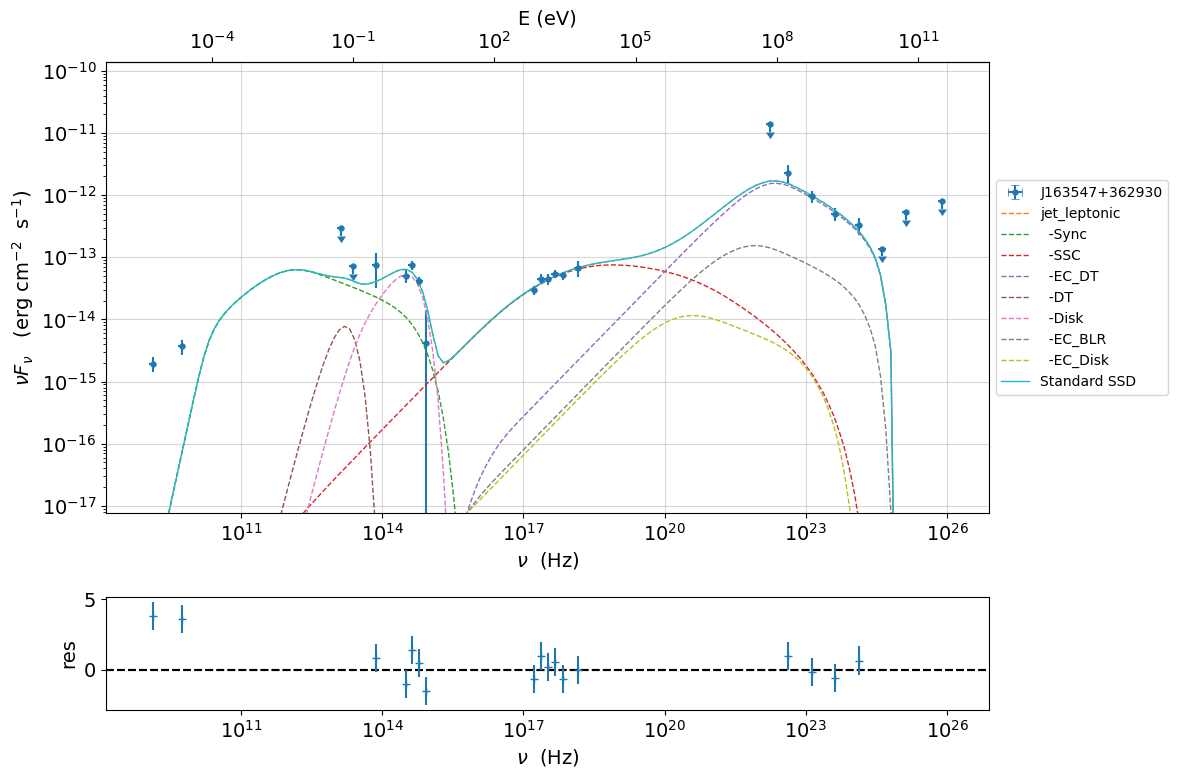

In [17]:
prefit_jet.set_par('BulkFactor',val=15.00)
prefit_jet.set_par('accr_eff',val=0.083)
prefit_jet.eval()

prefit_model=FitModel(jet=prefit_jet, name='Standard SSD',
                      template=None)

#ebl_franceschini=EBLAbsorptionTemplate.from_name('Franceschini_2008')
#prefit_model.add_component(ebl_franceschini)

#prefit_model.link_par(par_name='z_cosm',
#                      from_model='Franceschini_2008',
#                      to_model='jet_leptonic')

#prefit_model.composite_expr='(jet_leptonic)*Franceschini_2008'


prefit_model.jet_leptonic._blob.N_THREADS=8

prefit_model.free('jet_leptonic','R_H')
prefit_model.freeze('jet_leptonic','theta')
prefit_model.freeze('jet_leptonic','theta_open')
prefit_model.freeze('jet_leptonic','gmax')
prefit_model.freeze('jet_leptonic','gmin')
prefit_model.freeze('jet_leptonic','z_cosm')
prefit_model.freeze('jet_leptonic','accr_eff')
prefit_model.freeze('jet_leptonic','tau_DT')
prefit_model.freeze('jet_leptonic','tau_BLR')

prefit_model.jet_leptonic.parameters.R_H.fit_range=[5.0e+17,3.0e+18]
prefit_model.jet_leptonic.parameters.B.fit_range=[0.010,0.100]
prefit_model.jet_leptonic.parameters.BulkFactor.fit_range=[10.0,25.0]
prefit_model.jet_leptonic.parameters.N.fit_range=[4.00e+02,2.00e+03]
prefit_model.jet_leptonic.parameters.gamma_break.fit_range=[8.00e+02,2.00e+03]
prefit_model.jet_leptonic.parameters.p.fit_range=[1.35e+00,1.60e+00]
prefit_model.jet_leptonic.parameters.p_1.fit_range=[3.00e+00,3.80e+00]
prefit_model.jet_leptonic.parameters.R_inner_Sw.fit_range=[3.0e+00,1.5e+01]
prefit_model.jet_leptonic.parameters.R_ext_Sw.fit_range=[5.000e+01,1.00e+03]
prefit_model.jet_leptonic.parameters.M_BH.fit_range=[5.0000e+08,2.0000e+9]
prefit_model.jet_leptonic.parameters.T_DT.fit_range=[1.00000e+02,1.000e+03]
prefit_model.jet_leptonic.parameters.L_Disk.fit_range=[1.00e+46,5.00e+46]
model_minimizer_minuit=ModelMinimizer('minuit')
best_fit_minuit=model_minimizer_minuit.fit(prefit_model,sed_data,10**8.,10**30.0,
                                           fitname='Sum',repeat=3, use_UL=True)
prefit_model.eval()
best_fit_minuit.save_report('Report_PrePre3.pkl')
prefit_model.save_model('PrePre_model3.pkl')
model_minimizer_minuit.save_model('model_minimizer_PrePre3.pkl')
prefit_model.show_model()
prefit_model.jet_leptonic.energetic_report()
p2=prefit_model.plot_model(sed_data=sed_data)
p2.save('PrePre_model3.png')
print(prefit_model.jet_leptonic.get_beaming())

==> par R is now depending on ['R_H', 'theta_open'] according to expr:R =
np.tan((theta_open*np.pi/180))*R_H
==> par R_BLR_in is now depending on ['L_Disk'] according to expr:R_BLR_in =
3E17*(L_Disk/1E46)**0.5
==> par R_BLR_out is now depending on ['R_BLR_in'] according to expr:R_BLR_out =
R_BLR_in*1.1
==> par R_DT is now depending on ['L_Disk'] according to expr:R_DT =
2E19*(L_Disk/1E46)**0.5
19.10719166034305


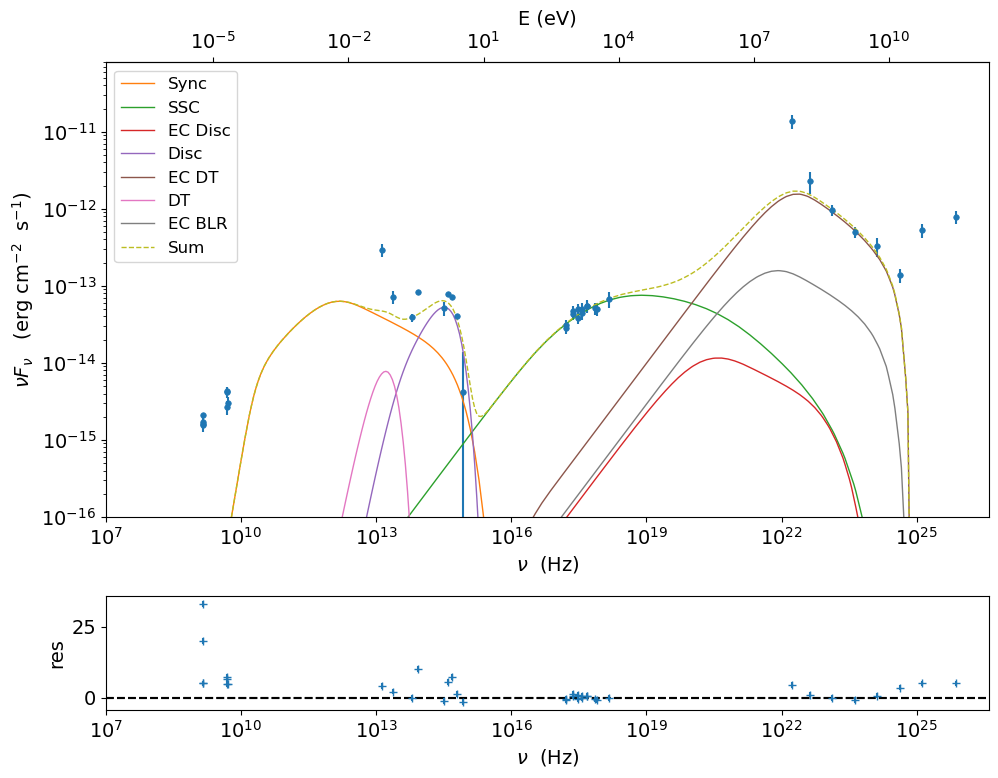

In [7]:
plt.rcParams['figure.dpi'] = 200
d=np.genfromtxt('sed2.txt')
data=Data(n_rows=d.shape[0])
data.set_field('x',d[:,0])
data.set_field('y',d[:,1])
data.set_field('dy',value=d[:,2])
#data.table[22]['UL']=True
#data.table[23]['UL']=True
data.set_meta_data('z',3.647763)
data.set_meta_data('UL_CL', 0.95)
data.set_meta_data('restframe','obs')
data.set_meta_data('data_scale','lin-lin')
data.set_meta_data('obj_name','J163547+362930')

#sed_data = ObsData.load('J163547_data.pkl')
sed_data=ObsData(data_table=data)

prefit_jet=Jet(name='jet_leptonic',electron_distribution='bkn',beaming_expr='bulk_theta')
#prefit_jet.set_external_field_transf('disk')
prefit_jet.add_EC_component(['EC_Disk',"EC_DT","EC_BLR"],disk_type='MultiBB')
prefit_jet.add_user_par(name='theta_open',val=3,units='deg')
prefit_jet.make_dependent_par(par='R', depends_on=['R_H','theta_open'],
                              par_expr='np.tan((theta_open*np.pi/180))*R_H')
prefit_jet.make_dependent_par(par='R_BLR_in', depends_on=['L_Disk'], par_expr='3E17*(L_Disk/1E46)**0.5')
prefit_jet.make_dependent_par(par='R_BLR_out', depends_on=['R_BLR_in'], par_expr='R_BLR_in*1.1')
prefit_jet.make_dependent_par(par='R_DT', depends_on=['L_Disk'], par_expr='2E19*(L_Disk/1E46)**0.5')

gmin=1
gmax=20000
N=921.4208
gamma_break=946.3835
p=1.446258
p_1=3.576325
T_DT=926.8273
R_DT=2.373137E+019
tau_DT=0.1
R_inner_Sw=9.274387
R_ext_Sw=841.166
accr_eff=0.083
M_BH=1102905000
tau_BLR=0.1
R_BLR_in=3.559706E+017
R_BLR_out=3.915677E+017
L_Disk=1.407945E+046
R=7.861166E+016
R_H=1.5E+018
B=0.06558658
NH_cold_to_rel_e=0.1
theta=3
BulkFactor=19.03681
z_cosm=3.647763
theta_open=3

prefit_jet.set_par('gmin',val=gmin)
prefit_jet.set_par('gmax',val=gmax)
prefit_jet.set_par('N',val=N)
prefit_jet.set_par('gamma_break',val=gamma_break)
prefit_jet.set_par('p',val=p)
prefit_jet.set_par('p_1',val=p_1)
prefit_jet.set_par('R_inner_Sw',val=R_inner_Sw)
prefit_jet.set_par('R_ext_Sw',val=R_ext_Sw)
prefit_jet.set_par('accr_eff',val=accr_eff)
prefit_jet.set_par('M_BH',val=M_BH)
prefit_jet.set_par('T_DT',val=T_DT)
prefit_jet.set_par('tau_DT',val=tau_DT)
prefit_jet.set_par('tau_BLR',val=tau_BLR)
prefit_jet.set_par('L_Disk',val=L_Disk)
prefit_jet.set_par('R_H',val=R_H)
prefit_jet.set_par('B',val=B)
prefit_jet.set_par('theta',val=theta)
prefit_jet.set_par('theta',val=theta_open)
prefit_jet.set_par('BulkFactor',val=BulkFactor)
prefit_jet.set_par('z_cosm',val=z_cosm)
prefit_jet.eval()
p=prefit_jet.plot_model(sed_data=sed_data, frame='obs')
p.add_residual_plot(prefit_jet,sed_data)
p.sedplot.legend(loc='upper left',fontsize=12)
p.sedplot.grid(False)
p.setlim(x_min=1e7,x_max=4e26,y_min=1.0e-16,y_max=8e-11)
legend_labels = ['Sync', 'SSC', 'EC Disc', 'Disc', 'EC DT', 'DT', 'EC BLR', 'Sum']
p.sedplot.legend(labels = legend_labels, loc='upper left', fontsize=12)
p.save('PrePre_model_3.png')
print(prefit_jet.get_beaming())
prefit_jet.save_model('prefit_SSD_3.pkl')